### Import Necessary Liabraries

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
# Load Train and Test Data
Train = np.loadtxt('train.csv')
TrainLabels = np.loadtxt('trainLabel.csv').astype(int)
Test = np.loadtxt('test.csv')
TestLabels = np.loadtxt('testLabel.csv').astype(int)

np.random.seed(0)
np.random.shuffle(Train)
np.random.seed(0)
np.random.shuffle(TrainLabels)
np.random.seed(0)
np.random.shuffle(Test)
np.random.seed(0)
np.random.shuffle(TestLabels)

In [3]:
# split train and validation data
p = int((len(Train)*0.8))

Train_p = Train[:p]
Val = Train[p:]

TrainLabels_p = TrainLabels[:p]
ValLabels = TrainLabels[p:]

print(len(Train_p), " ", len(Val))

912   228


In [4]:
# Initialize Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.from_numpy(features).float()
        self.labels = torch.from_numpy(labels).long()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature_vec = self.features[idx]
        label = self.labels[idx]
        return feature_vec, label

In [5]:
# Define dataloader with batch size
iTrain_dataloader = DataLoader(CustomDataset(Train_p, TrainLabels_p), batch_size=32)
iVal_dataloader = DataLoader(CustomDataset(Val, ValLabels), batch_size=32)
iTest_dataloader = DataLoader(CustomDataset(Test, TestLabels), batch_size=32)

In [6]:
# Check the labels
iTrain_dataloader.dataset.labels[1]

tensor(2)

In [7]:
# Check feature size
iTrain_dataloader.dataset.features.size()

torch.Size([912, 6075])

In [8]:
# Check label size
iTrain_dataloader.dataset.labels.size()

torch.Size([912])

### Build Sequential nn Model

In [26]:
class INeuralNetwork(nn.Module):
    def __init__(self):
        super(INeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(6075, 512),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 3),
            #nn.ReLU(),
            nn.LogSoftmax(dim=1),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        prediction = self.model(x)
        return prediction

In [27]:
iModel = INeuralNetwork()
print(iModel)

INeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=6075, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=3, bias=True)
    (7): LogSoftmax(dim=1)
  )
)


In [28]:
def iTraining(dataloader, model, loss_fn, optimizer):
    full_loss = 0
    correct = 0
    
    for (X, y) in dataloader:
        
        pred = model(X)
        loss = loss_fn(pred, y)
        full_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    full_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print("Training Loss ", full_loss)
    print("Training Accuracy ", correct)
    return full_loss, correct

In [29]:
def iTesting(dataloader, model, loss_fn):
    test_loss = 0
    correct = 0
    predLabels = []
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            predLabels.append(pred.argmax(1).tolist())
    
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print("Testing loss ", test_loss)
    print("Testing Accuracy ", correct)
    predLabels = list(np.concatenate(predLabels).flat)
    return test_loss, correct, predLabels

In [30]:
iModel = INeuralNetwork()
iLoss_fn = nn.CrossEntropyLoss()
iOptimizer = torch.optim.Adam(iModel.parameters(), lr = 0.001)

iTrainingAcc = []
iTrainingLoss = []
iValidationAcc = []
iValidationLoss = []

for e in range(150):
    print("Epoch ", e+1, "\n-----------------------------------")
    iTLoss, iTAcc = iTraining(iTrain_dataloader, iModel, iLoss_fn, iOptimizer)
    iTrainingAcc.append(iTAcc)
    iTrainingLoss.append(iTLoss)
    iVLoss, iVAcc, x = iTesting(iVal_dataloader, iModel, iLoss_fn)
    iValidationAcc.append(iVAcc)
    iValidationLoss.append(iVLoss)
    print()
x, y, iPredLabels = iTesting(iTest_dataloader, iModel, iLoss_fn)

Epoch  1 
-----------------------------------
Training Loss  2.9064054694669
Training Accuracy  0.34649122807017546
Testing loss  1.5093818753957748
Testing Accuracy  0.32894736842105265

Epoch  2 
-----------------------------------
Training Loss  1.3112104103483002
Training Accuracy  0.37719298245614036
Testing loss  1.1808148175477982
Testing Accuracy  0.32894736842105265

Epoch  3 
-----------------------------------
Training Loss  1.1933940998439132
Training Accuracy  0.42105263157894735
Testing loss  1.3281030505895615
Testing Accuracy  0.37719298245614036

Epoch  4 
-----------------------------------
Training Loss  1.1801274274957592
Training Accuracy  0.4550438596491228
Testing loss  1.0719103068113327
Testing Accuracy  0.41228070175438597

Epoch  5 
-----------------------------------
Training Loss  1.0935521947926488
Training Accuracy  0.48903508771929827
Testing loss  1.4686468690633774
Testing Accuracy  0.39473684210526316

Epoch  6 
-----------------------------------
Tra

Training Loss  0.48845133005545055
Training Accuracy  0.7971491228070176
Testing loss  0.9134262911975384
Testing Accuracy  0.6052631578947368

Epoch  46 
-----------------------------------
Training Loss  0.44710100904620925
Training Accuracy  0.8223684210526315
Testing loss  1.3341658487915993
Testing Accuracy  0.5701754385964912

Epoch  47 
-----------------------------------
Training Loss  0.613634659298535
Training Accuracy  0.7346491228070176
Testing loss  0.9968388192355633
Testing Accuracy  0.5657894736842105

Epoch  48 
-----------------------------------
Training Loss  0.5058319054800888
Training Accuracy  0.7763157894736842
Testing loss  1.0929393791593611
Testing Accuracy  0.5482456140350878

Epoch  49 
-----------------------------------
Training Loss  0.4483044584249628
Training Accuracy  0.8234649122807017
Testing loss  1.2291425317525864
Testing Accuracy  0.5350877192982456

Epoch  50 
-----------------------------------
Training Loss  0.5415887514065052
Training Accura

Training Loss  0.43341243832275783
Training Accuracy  0.8168859649122807
Testing loss  1.0013626962900162
Testing Accuracy  0.6359649122807017

Epoch  90 
-----------------------------------
Training Loss  0.32682637690470134
Training Accuracy  0.8859649122807017
Testing loss  1.6890228316187859
Testing Accuracy  0.5394736842105263

Epoch  91 
-----------------------------------
Training Loss  0.5023472052195976
Training Accuracy  0.7905701754385965
Testing loss  1.0656695552170277
Testing Accuracy  0.5789473684210527

Epoch  92 
-----------------------------------
Training Loss  0.3750260942454996
Training Accuracy  0.8486842105263158
Testing loss  1.3407736620865762
Testing Accuracy  0.5789473684210527

Epoch  93 
-----------------------------------
Training Loss  0.40905689859184724
Training Accuracy  0.8333333333333334
Testing loss  2.8143157213926315
Testing Accuracy  0.42105263157894735

Epoch  94 
-----------------------------------
Training Loss  0.6967677774614301
Training Acc

Training Loss  0.2938145062532918
Training Accuracy  0.8991228070175439
Testing loss  3.899017035961151
Testing Accuracy  0.42105263157894735

Epoch  134 
-----------------------------------
Training Loss  0.5954580326275579
Training Accuracy  0.756578947368421
Testing loss  2.002734676003456
Testing Accuracy  0.5350877192982456

Epoch  135 
-----------------------------------
Training Loss  0.15266521210814343
Training Accuracy  0.944078947368421
Testing loss  1.900137297809124
Testing Accuracy  0.5964912280701754

Epoch  136 
-----------------------------------
Training Loss  0.3184113571869916
Training Accuracy  0.8739035087719298
Testing loss  1.332819264382124
Testing Accuracy  0.618421052631579

Epoch  137 
-----------------------------------
Training Loss  0.21700736655500427
Training Accuracy  0.9199561403508771
Testing loss  2.0601757168769836
Testing Accuracy  0.5789473684210527

Epoch  138 
-----------------------------------
Training Loss  0.18524265417764926
Training Accur

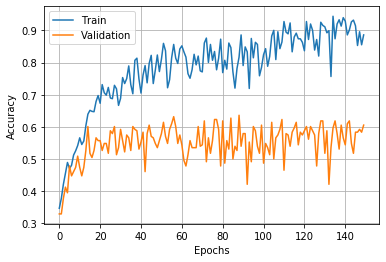

In [31]:
#Plot Accuracy
plt.plot(iTrainingAcc)
plt.plot(iValidationAcc)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

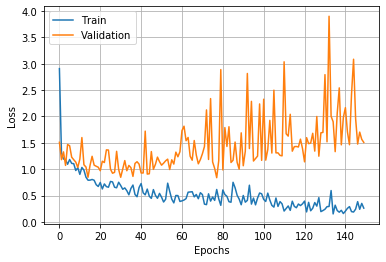

In [32]:
#Plot Loss
plt.plot(iTrainingLoss)
plt.plot(iValidationLoss)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])

### Classification Report

In [33]:
print(classification_report(TestLabels, iPredLabels))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       100
           1       0.94      0.91      0.92       100
           2       0.84      0.90      0.87       100

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300



### Confusion Matrix

Text(33.0, 0.5, 'Truth')

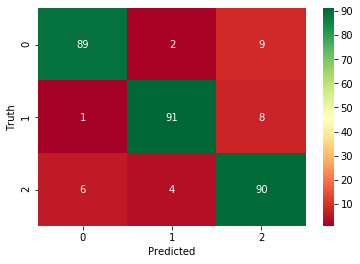

In [34]:
iConf_mat = confusion_matrix(TestLabels, iPredLabels)

sn.heatmap(iConf_mat, annot=True, cmap='RdYlGn', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')